Task 1: Embed the Neo4j data

First let's start with loading the relationships between nodes in neo4j database


In [83]:
!pip install neo4j

In [84]:
from neo4j import GraphDatabase
from google.colab import userdata

In [85]:
uri = userdata.get("NEO4J_URI")
user = userdata.get("NEO4J_USERNAME")
password = userdata.get("NEO4J_PASSWORD")

In [86]:
driver = GraphDatabase.driver(uri, auth=(user, password))

In [87]:
def run_query(query, parameters=None):
    with driver.session() as session:
        results = session.run(query, parameters)
        return [dict(record) for record in results]

In [88]:
# query = "MATCH (n) RETURN n"
query = """
MATCH (p)-[r]->(m)
RETURN p, r, m
"""
result = run_query(query)
print(len(result))
cont_formatted_res = {}
for res in result:
  item_one = dict(res["p"])
  item_two = dict(res["m"])
  relationship = res["r"].type
  if item_one["name"] in cont_formatted_res:
    if relationship == "TEAMMATES":
      cont_formatted_res[item_one["name"]]["teamates"].append(item_two["name"])
    elif relationship == "PLAYS_FOR":
      cont_formatted_res[item_one["name"]]["club_own"] = item_two["name"]
    elif relationship == "PLAYED_AGAINST":
      cont_formatted_res[item_one["name"]]["club_against"].append(item_two["name"])
    elif relationship == "COACHES":
      cont_formatted_res[item_one["name"]]["coaches"] = item_two["name"]
    elif relationship == "COACHES_FOR":
          cont_formatted_res[item_one["name"]]["coaches_for"] = item_two["name"]
  else:
    cont_formatted_res[item_one["name"]] = {"teamates": [],"club_own": "",  "club_against": [], "coaches": [], "coaches_for":""}
    if relationship == "TEAMMATES":
      cont_formatted_res[item_one["name"]]["teamates"].append(item_two["name"])
    elif relationship == "PLAYS_FOR":
      cont_formatted_res[item_one["name"]]["club_own"] = item_two["name"]
    elif relationship == "PLAYED_AGAINST":
      cont_formatted_res[item_one["name"]]["club_against"].append(item_two["name"])
    elif relationship == "COACHES":
      cont_formatted_res[item_one["name"]]["coaches"].append(item_two["name"])
    elif relationship == "COACHES_FOR":
          cont_formatted_res[item_one["name"]]["coaches_for"] = item_two["name"]
for element in cont_formatted_res:
  print(element, " : ", cont_formatted_res[element])




162
Russell Westbrook  :  {'teamates': ['LeBron James', 'Anthony Davis', 'LeBron James', 'Anthony Davis'], 'club_own': 'LA Lakers', 'club_against': ['Memphis Grizzlies', 'Memphis Grizzlies', 'Brooklyn Nets', 'Philadelphia 76ers', 'Memphis Grizzlies', 'Memphis Grizzlies', 'Brooklyn Nets', 'Philadelphia 76ers'], 'coaches': [], 'coaches_for': ''}
LeBron James  :  {'teamates': ['Russell Westbrook', 'Anthony Davis', 'Russell Westbrook', 'Anthony Davis'], 'club_own': 'LA Lakers', 'club_against': ['Memphis Grizzlies', 'Memphis Grizzlies', 'Brooklyn Nets', 'Philadelphia 76ers', 'Memphis Grizzlies', 'Memphis Grizzlies', 'Brooklyn Nets', 'Philadelphia 76ers'], 'coaches': [], 'coaches_for': ''}
Anthony Davis  :  {'teamates': ['Russell Westbrook', 'LeBron James', 'Russell Westbrook', 'LeBron James'], 'club_own': 'LA Lakers', 'club_against': ['Memphis Grizzlies', 'Memphis Grizzlies', 'Brooklyn Nets', 'Philadelphia 76ers', 'Memphis Grizzlies', 'Memphis Grizzlies', 'Brooklyn Nets', 'Philadelphia 76er

In [89]:
query = """
MATCH (n) RETURN (n)
"""

node_property_result = run_query(query)
print(len(node_property_result))
cont_players_data = """"""
cont_coaches_data = """"""
for node in node_property_result:
  if node['n']['name'] not in cont_formatted_res: continue
  if "PLAYER" in node["n"].labels:
    player_data = f"{node['n']['name']} is a player.{node['n']['name']} is {node['n']['age']} years old. {node['n']['name']}'s weight is {node['n']['weight']}. he wears a shirt numbered {node['n']['number']}. {node['n']['name']}'s height is {node['n']['height']}.{node['n']['name']} plays for {cont_formatted_res[node['n']['name']]['club_own']}."
    for teamate in cont_formatted_res[node['n']['name']]["teamates"]:
      player_data += f"{node['n']['name']} is teamates with " + teamate + "."
    for club in cont_formatted_res[node['n']['name']]["club_against"]:
      player_data += f"{node['n']['name']} has played against " + club + "."
    cont_players_data += player_data + "\n"
  elif "COACH"in node["n"].labels:
    coach_data = f"{node['n']['name']} is a coach. {node['n']['name']} is a coach of {cont_formatted_res[node['n']['name']]['coaches_for']}."
    for player in cont_formatted_res[node['n']['name']]["coaches"]:
      coach_data += f"{node['n']['name']} coaches {player}."
    cont_coaches_data += coach_data + "\n"
print(cont_players_data)
print(cont_coaches_data)



50
Russell Westbrook is a player.Russell Westbrook is 33 years old. Russell Westbrook's weight is 91. he wears a shirt numbered 0. Russell Westbrook's height is 1.91.Russell Westbrook plays for LA Lakers.Russell Westbrook is teamates with LeBron James.Russell Westbrook is teamates with Anthony Davis.Russell Westbrook is teamates with LeBron James.Russell Westbrook is teamates with Anthony Davis.Russell Westbrook has played against Memphis Grizzlies.Russell Westbrook has played against Memphis Grizzlies.Russell Westbrook has played against Brooklyn Nets.Russell Westbrook has played against Philadelphia 76ers.Russell Westbrook has played against Memphis Grizzlies.Russell Westbrook has played against Memphis Grizzlies.Russell Westbrook has played against Brooklyn Nets.Russell Westbrook has played against Philadelphia 76ers.
LeBron James is a player.LeBron James is 36 years old. LeBron James's weight is 113. he wears a shirt numbered 6. LeBron James's height is 2.06.LeBron James plays for 

Now let's try to create a text-embeddings and push it to pinecone database

In [90]:
!pip install -q accelerate langchain bitsandbytes

In [91]:
!pip install pinecone-client

In [92]:
!pip install llama_index sentence_transformers

In [93]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

user_agent = 'Mozilla/5.0 (iPhone; CPU iPhone OS 5_1 like Mac OS X) AppleWebKit/534.46 (KHTML, like Gecko) Version/5.1 Mobile/9B179 Safari/7534.48.3'

In [94]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 100,           # Usually chunk sizes are much larger than this
    chunk_overlap  = 20,        # Overlap is needed incase the text is split in odd places
    length_function = len,
)
text = text_splitter.split_text(cont_players_data + cont_coaches_data)
print(text)

["Russell Westbrook is a player.Russell Westbrook is 33 years old. Russell Westbrook's weight is 91.", "weight is 91. he wears a shirt numbered 0. Russell Westbrook's height is 1.91.Russell Westbrook", 'Westbrook plays for LA Lakers.Russell Westbrook is teamates with LeBron James.Russell Westbrook is', 'Westbrook is teamates with Anthony Davis.Russell Westbrook is teamates with LeBron James.Russell', 'James.Russell Westbrook is teamates with Anthony Davis.Russell Westbrook has played against Memphis', 'against Memphis Grizzlies.Russell Westbrook has played against Memphis Grizzlies.Russell Westbrook', 'Westbrook has played against Brooklyn Nets.Russell Westbrook has played against Philadelphia', 'Philadelphia 76ers.Russell Westbrook has played against Memphis Grizzlies.Russell Westbrook has', 'Westbrook has played against Memphis Grizzlies.Russell Westbrook has played against Brooklyn', 'against Brooklyn Nets.Russell Westbrook has played against Philadelphia 76ers.', "LeBron James is a

In [95]:
!pip install langchain-community

In [96]:
from langchain.embeddings import HuggingFaceEmbeddings, SentenceTransformerEmbeddings
from llama_index.legacy.embeddings.langchain import LangchainEmbedding

embed_model = LangchainEmbedding(
  HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
)

In [97]:
embeddings = []

for i in text:
    section_embedding = embed_model.get_text_embedding(i)
    embeddings.append(section_embedding)
    print(section_embedding)

[0.006101610139012337, -0.01190070528537035, 0.03928814455866814, 0.04962456226348877, -0.023192105814814568, 0.00214389618486166, -0.01017752941697836, 0.016473915427923203, 0.012461730279028416, -0.0014406226109713316, 0.045149046927690506, -0.01716831885278225, 0.052227932959795, -0.017397329211235046, 0.02084936760365963, 0.034885093569755554, -0.010046658106148243, -0.05181572213768959, 0.09791180491447449, 0.005553998053073883, -0.05622849613428116, -0.007754916790872812, -0.03408849239349365, 0.010156470350921154, -0.006632565055042505, -0.0038713905960321426, 0.06658674776554108, 0.020742515102028847, -0.051128145307302475, -0.03856944292783737, -0.020032595843076706, -0.0413556806743145, 0.010159524157643318, -0.047190673649311066, 1.6848972563821007e-06, -0.023875074461102486, 0.07206209003925323, 0.028938041999936104, 0.026143843308091164, -0.043450985103845596, 0.00741588743403554, -0.006431284826248884, -0.012338784523308277, -0.018472790718078613, -0.00951104424893856, -0

In [98]:
dimension = embed_model.get_text_embedding("coach")
print(dimension)
len(dimension)

[0.03801421821117401, 0.05874372273683548, -0.020996268838644028, 0.035253170877695084, 0.01828729547560215, 0.023809710517525673, -0.05333634838461876, -0.01527893915772438, 0.027451232075691223, 0.002254603896290064, 0.05254760757088661, -0.019365303218364716, -0.008623656816780567, -0.055210523307323456, 0.06412104517221451, -0.05228176712989807, -0.024502165615558624, -0.03694552928209305, 0.04172617197036743, -0.04799143597483635, 0.022002428770065308, 0.027494270354509354, 0.004892136435955763, 0.01592840626835823, -0.020395010709762573, -0.013338912278413773, 0.012968339025974274, 0.0043264939449727535, -0.0144821060821414, 0.007529078517109156, -0.0175801832228899, -0.022580713033676147, -0.039155591279268265, -0.054592620581388474, 1.9215972315578256e-06, 0.024349838495254517, 0.041954655200242996, -0.06957985460758209, 0.018608296290040016, -0.01139500830322504, 0.0660415068268776, 0.04981610178947449, -0.01220198068767786, -0.005143843125551939, -0.0027468863409012556, 0.075

768

In [99]:
from pinecone import Pinecone, ServerlessSpec
from google.colab import userdata

# initialize connection to pinecone
pinecone = Pinecone(
        api_key=userdata.get("PINECONE_API_KEY")
    )

# create the index if it does not exist already
index_name = 'neo4j-picone'
# if index_name not in pinecone.list_indexes():
#     pinecone.create_index(
#         index_name,
#         dimension=len(dimension),
#         metric='cosine',
#         spec=ServerlessSpec(
#             cloud=userdata.get("PINECONE_CLOUD"),
#             region=userdata.get("PINECONE_ENVIRONMENT")
#         )
#     )

# connect to the index
pinecone_index = pinecone.Index(index_name)
docs = []
for idx, i in enumerate(text):
  docs.append((
        str(idx),
        embeddings[idx],
        {'text': i},
    ))

pinecone_index.upsert(vectors= docs, show_progress = True)


{'upserted_count': 240}

In [100]:
!pip install together

In [101]:
def get_data_from_db(query):
    # embed query
    xq = embed_model.get_text_embedding(query)
    # query database
    result = pinecone_index.query(vector=xq, top_k=20, includeMetadata=True)
    matches = []
    for i in result['matches']:
      # filter by score
      if (i['score'] > 0.6):
        print(i.metadata['text'])
        # append best results
        matches.append(i.metadata['text'])
    return str(matches)

In [102]:

B_INST, E_INST = "[INST]", "[/INST]"
B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"
DEFAULT_SYSTEM_PROMPT = """\
  You will be given texts related to a certain topic. Write a summary response that answers the question based on what is discussed in the texts.
  Do not mention anything outside of what is provided. Don't answer anything outside the context you are provided.use only 10 words.
  If there isn't enough context, simply reply "This topic was not discussed previously"
  """

SYSTEM_PROMPT = B_SYS + DEFAULT_SYSTEM_PROMPT + E_SYS

def get_prompt(instruction):
    prompt_template =  B_INST + SYSTEM_PROMPT + instruction + E_INST
    return prompt_template

In [103]:
def format_prompt(query, context):
    return '''
    ### Texts:
    {context}

    ### Question:
    {query}
    '''.format(context=context, query=query)

In [104]:
from together import Together

client = Together(api_key=userdata.get("TOGETHER_API_KEY"))


<h1>FOR TASK 2: Use the same natural language query to fetch from both databases</h1>

In [105]:
import re
def nl_to_neoquery(nl_query):
    prompt = "give me a cypher query for a neo4j database for the following natural language query, use PLAYER in capital letter FOR NODES and TEAMMATES, COACHES, COACHES_FOR,PLAYS_FOR and PLAYED_AGAINST for relationships, return only the query in square bracket. If you are returning a relation, use n - r -> m format,  and dont comment on anything else."
    stream = client.chat.completions.create(
    model="mistralai/Mixtral-8x7B-Instruct-v0.1",
    messages=[{"role": "user", "content": prompt + nl_query}],
    stream=True,
    )
    query = """"""
    for chunk in stream:
      query += chunk.choices[0].delta.content or ""
    return query

In [106]:
# Define a function that runs the model
def answer(query):
    context = get_data_from_db(query)

    prompt = format_prompt(query, context)
    prompt_template = get_prompt(prompt)

    stream = client.chat.completions.create(
    model="mistralai/Mixtral-8x7B-Instruct-v0.1",
    messages=[{"role": "user", "content": prompt_template}],
    stream=True,
    )

    for chunk in stream:
        print(chunk.choices[0].delta.content or "", end="", flush=True)

    # return generate(prompt_template)

In [107]:
answer("Which teams did LeBron James played against?")

James has played against Memphis Grizzlies.LeBron James has played against Brooklyn Nets.LeBron
James has played against Memphis Grizzlies.LeBron James has played against Brooklyn Nets.LeBron
against Memphis Grizzlies.LeBron James has played against Memphis Grizzlies.LeBron James has played
against Memphis Grizzlies.LeBron James has played against Memphis Grizzlies.LeBron James has played
James is teamates with Anthony Davis.LeBron James has played against Memphis Grizzlies.LeBron James
James is teamates with Anthony Davis.LeBron James has played against Memphis Grizzlies.LeBron James
Nets.LeBron James has played against Philadelphia 76ers.LeBron James has played against Memphis
Nets.LeBron James has played against Philadelphia 76ers.LeBron James has played against Memphis
James has played against Brooklyn Nets.LeBron James has played against Philadelphia 76ers.
James has played against Brooklyn Nets.LeBron James has played against Philadelphia 76ers.
against Memphis Grizzlies.James Ha

<h1>The following kind of questions provide answer:</h1>
  <ul>
    <li>Who are the teamates of LeBron James?</li>
    <li>Who Coaches LA Lakers?</li>
    <li>Are Kevin Durant and James Harden teamates?</li>
  </ul>
   
   

In [109]:
!pip install neo4j networkx matplotlib plotly

In [110]:
import neo4j
import networkx as nx


In [114]:
def answer_2(query):
    context = get_data_from_db(query)

    prompt = format_prompt(query, context)
    prompt_template = get_prompt(prompt)

    stream = client.chat.completions.create(
    model="mistralai/Mixtral-8x7B-Instruct-v0.1",
    messages=[{"role": "user", "content": prompt_template}],
    stream=True,
    )

    for chunk in stream:
        print(chunk.choices[0].delta.content or "", end="", flush=True)
    query_neo = nl_to_neoquery(query)
    neo_result = run_query(query_neo[10:-3])
    print(neo_result)
    # return generate(prompt_template)

In [115]:
answer_2("Which teams did LeBron James played against?")

James has played against Memphis Grizzlies.LeBron James has played against Brooklyn Nets.LeBron
James has played against Memphis Grizzlies.LeBron James has played against Brooklyn Nets.LeBron
against Memphis Grizzlies.LeBron James has played against Memphis Grizzlies.LeBron James has played
against Memphis Grizzlies.LeBron James has played against Memphis Grizzlies.LeBron James has played
James is teamates with Anthony Davis.LeBron James has played against Memphis Grizzlies.LeBron James
James is teamates with Anthony Davis.LeBron James has played against Memphis Grizzlies.LeBron James
Nets.LeBron James has played against Philadelphia 76ers.LeBron James has played against Memphis
Nets.LeBron James has played against Philadelphia 76ers.LeBron James has played against Memphis
James has played against Brooklyn Nets.LeBron James has played against Philadelphia 76ers.
James has played against Brooklyn Nets.LeBron James has played against Philadelphia 76ers.
against Memphis Grizzlies.James Ha

<h1><b>Visualizing general relationships within the database using data from the query 'call call db.schema.visualizatione</b></h1>

In [138]:
get_general_relationship = run_query("call db.schema.visualization")[0]
print(len(get_general_relationship),get_general_relationship)

2 {'nodes': [<Node element_id='-127' labels=frozenset({'PLAYER'}) properties={'name': 'PLAYER', 'indexes': [], 'constraints': []}>, <Node element_id='-129' labels=frozenset({'TEAM'}) properties={'name': 'TEAM', 'indexes': [], 'constraints': []}>, <Node element_id='-128' labels=frozenset({'COACH'}) properties={'name': 'COACH', 'indexes': [], 'constraints': []}>], 'relationships': [<Relationship element_id='-148' nodes=(<Node element_id='-128' labels=frozenset({'COACH'}) properties={'name': 'COACH', 'indexes': [], 'constraints': []}>, <Node element_id='-129' labels=frozenset({'TEAM'}) properties={'name': 'TEAM', 'indexes': [], 'constraints': []}>) type='COACHES_FOR' properties={'name': 'COACHES_FOR'}>, <Relationship element_id='-147' nodes=(<Node element_id='-127' labels=frozenset({'PLAYER'}) properties={'name': 'PLAYER', 'indexes': [], 'constraints': []}>, <Node element_id='-129' labels=frozenset({'TEAM'}) properties={'name': 'TEAM', 'indexes': [], 'constraints': []}>) type='PLAYS_FOR' 

In [141]:
for element in get_general_relationship:
  print(element, " : ", get_general_relationship[element])

nodes  :  [<Node element_id='-127' labels=frozenset({'PLAYER'}) properties={'name': 'PLAYER', 'indexes': [], 'constraints': []}>, <Node element_id='-129' labels=frozenset({'TEAM'}) properties={'name': 'TEAM', 'indexes': [], 'constraints': []}>, <Node element_id='-128' labels=frozenset({'COACH'}) properties={'name': 'COACH', 'indexes': [], 'constraints': []}>]
relationships  :  [<Relationship element_id='-148' nodes=(<Node element_id='-128' labels=frozenset({'COACH'}) properties={'name': 'COACH', 'indexes': [], 'constraints': []}>, <Node element_id='-129' labels=frozenset({'TEAM'}) properties={'name': 'TEAM', 'indexes': [], 'constraints': []}>) type='COACHES_FOR' properties={'name': 'COACHES_FOR'}>, <Relationship element_id='-147' nodes=(<Node element_id='-127' labels=frozenset({'PLAYER'}) properties={'name': 'PLAYER', 'indexes': [], 'constraints': []}>, <Node element_id='-129' labels=frozenset({'TEAM'}) properties={'name': 'TEAM', 'indexes': [], 'constraints': []}>) type='PLAYS_FOR' pr

In [145]:
nodes = [dict(node)['name'] for node in get_general_relationship['nodes']]
edges = [dict(relathionship)['name'] for relathionship in get_general_relationship['relationships']]
print(nodes)
print(edges)

['PLAYER', 'TEAM', 'COACH']
['COACHES_FOR', 'PLAYS_FOR', 'TEAMMATES', 'COACHES', 'PLAYED_AGAINST']


In [156]:
G = nx.DiGraph()
for node in nodes:  G.add_node(node, label=node)
for edge in edges:
  if edge == "COACHES":
     G.add_edge("COACH", "TEAM", label=edge)
  elif edge == "PLAYS_FOR":
     G.add_edge("PLAYER", "TEAM", label=edge)
  elif edge == "COACHES_FOR":
     G.add_edge("COACH", "PLAYER", label=edge)
  elif edge == "TEAMMATES":
     G.add_edge("PLAYER", "PLAYER", label=edge)
  elif edge == "PLAYED_AGAINST":
     G.add_edge("PLAYER", "TEAM", label=edge)


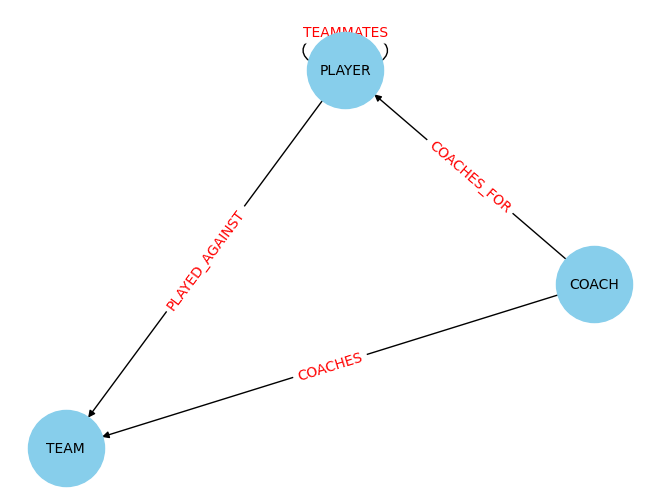

In [157]:
import matplotlib.pyplot as plt

# Get labels for nodes and edges
node_labels = nx.get_node_attributes(G, 'label')
edge_labels = nx.get_edge_attributes(G, 'label')

# Draw the graph
pos = nx.spring_layout(G)  # Positioning algorithm
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=3000, node_color="skyblue", font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

# Show the plot
plt.show()